In [9]:
import os
import cv2
import numpy as np
from PIL import Image
from keras.utils import to_categorical
from keras.models import Model, Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
from matplotlib import pyplot as plt
from PIL import Image
from time import time
import logging#程序进展信息
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split#分割数据集
#from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people#下载数据集
from sklearn.model_selection import GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [10]:
ck_data = h5py.File('./CK_data.h5', 'r', driver='core')
X_data = np.expand_dims(np.asarray(ck_data['data_pixel']), axis=-1)
X_data = X_data.reshape((981,48*48))
y_data = np.asarray(ck_data['data_label'])
y_data = to_categorical(y_data)
n_classes = y_data.shape[1]

X_train, X_validation, y_train, y_validation = train_test_split(X_data, y_data, test_size=0.2,random_state=3)

print('Training: ',X_train.shape)
print('Validation: ',X_validation.shape)

Training:  (784, 2304)
Validation:  (197, 2304)


In [11]:
n_components = 10
pca =PCA(svd_solver='randomized',n_components=n_components,whiten=True).fit(X_train)
X_train_pca = pca.transform(X_train)      #得到训练集投影系数
X_val_pca = pca.transform(X_validation) 

In [12]:
eigenfaces = pca.components_.reshape((n_components, 48, 48))

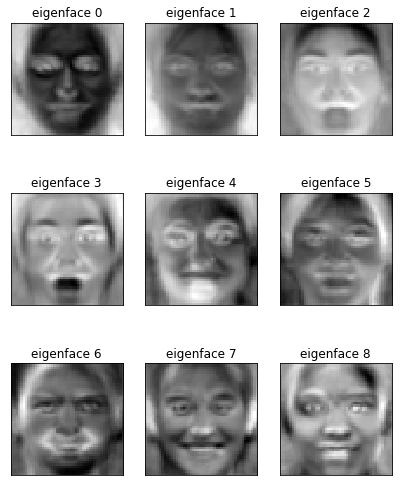

In [13]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=3):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
 
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, 48, 48)
plt.show()

In [14]:
y_train_ = np.argmax(y_train, axis=-1)
y_train_.shape

(784,)

In [15]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
#class_weight='balanced'表示调整各类别权重，权重与该类中样本数成反比，
#防止模型过于拟合某个样本数量过大的类
clf = clf.fit(X_train_pca, y_train_)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 3.722s
Best estimator found by grid search:
SVC(C=50000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [16]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_val_pca)
print("done in %0.3fs" % (time() - t0))
y_val = np.argmax(y_validation, axis=-1)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.002s
             precision    recall  f1-score   support

          0       0.92      0.94      0.93        35
          1       0.95      0.90      0.92        40
          2       0.83      1.00      0.91        10
          3       1.00      1.00      1.00        38
          4       0.91      1.00      0.95        20
          5       1.00      0.93      0.97        46
          6       1.00      1.00      1.00         8

avg / total       0.96      0.95      0.95       197

[[33  2  0  0  0  0  0]
 [ 3 36  1  0  0  0  0]
 [ 0  0 10  0  0  0  0]
 [ 0  0  0 38  0  0  0]
 [ 0  0  0  0 20  0  0]
 [ 0  0  1  0  2 43  0]
 [ 0  0  0  0  0  0  8]]
